In [1]:
import xarray as xr
import numpy as np
import requests
from tqdm import tqdm
from os import listdir
from matplotlib import pyplot as plt
path_save = "./data_SMR/"
baseurl = 'http://odin.rss.chalmers.se/level2_download/ALL-Meso-v3.0.0/'
month = '01'
def download_from_url(url):
    filename = url.split('/')[-1]
    #download the nc file if not done already
    if filename not in listdir(path_save):
        r = requests.get(url)
        with open(path_save + filename, "wb") as handle:
            for data in tqdm(r.iter_content()):
                handle.write(data)
    return 

In [2]:
#interpolate in altitude grid
def alt_interp(ds, profile, alt_range):
  profile_alt = []
  # Apriori_alt=[]
  for i in range(len(ds.time)):
      profile_alt.append(np.interp(alt_range,ds.Altitude.isel(time=i),ds[profile].where(ds.MeasResponse>0.8).isel(time=i)))
      # Apriori_alt.append(np.interp(alt_range, ds.Altitude.isel(time=i),ds.Apriori.isel(time=i)))
  ds_alt = xr.Dataset({profile: (["time","altitude"],profile_alt), 
                      # "Apriori": (["time","altitude"],Apriori_alt),
                      "latitude":(["time"], ds.Lat1D.data),
                      "longitude":(["time"], ds.Lon1D.data),
                      }, 
                    coords={
                      "altitude": (["altitude"], alt_range),
                      "time":(["time"], ds.Time.data)
                      })
  return ds_alt


## O3

In [8]:
# url = baseurl+'Odin-SMR_L2_ALL19lowTunc_O3-557-GHz-45-to-90-km_2009-{}.nc'.format(month)
url = 'http://odin.rss.chalmers.se/level2_download/ALL-Strat-v3.0.0/Odin-SMR_L2_ALL-Strat-v3.0.0_O3-545-GHz-20-to-85-km_2009-02.nc'
download_from_url(url)
filename = url.split('/')[-1]

75334798it [00:36, 2050818.53it/s]


In [9]:
#load nc file
with xr.open_dataset('./data_SMR/'+filename) as ds:
    ds = ds.assign_coords(pressure=ds.Pressure[0]).swap_dims({"level":"pressure"})
    ds = ds.rename(dict(Profile='O3'))

In [10]:
#interpolate O3 in altitude grid
alt_range = np.arange(50,101,1)*1000 #meter
profile = 'O3'
ds_alt = alt_interp(ds, profile, alt_range)


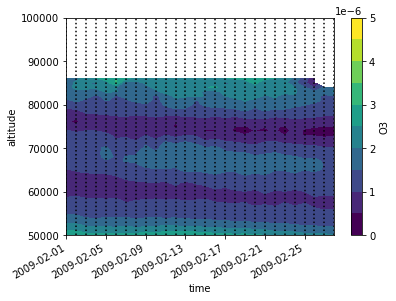

In [11]:
#daily average in NP (lat > 70 degree)
ds_daily = ds_alt.where(ds_alt.latitude>70).resample(time='1D').mean('time')[profile]
ds_daily.interpolate_na(
    'time',
    # 'altitude'
).plot.contourf(
    x='time', levels=np.linspace(0,5,11)*1e-6,
)
#days with data
days_with_data = ds_daily.dropna('time', how='all').time.data
for t in days_with_data:
    plt.axvline(x=t, color='k', ls=':')

In [12]:
# make daily mean, std, count for all latitude bins
def mk_daily(ds_alt, data_vars):
    lat_bins = np.linspace(-90, 90, 10)
    lat_labels = []
    daily_mean = []
    daily_count = []
    daily_std = []
    for label, group in ds_alt[data_vars].groupby_bins(ds_alt.latitude, bins=lat_bins):
        lat_labels.append(label.mid) #make the labels to string so that we can save in nc file
        resampled = group.resample(time='1D')
        daily_mean.append(resampled.mean('time').rename({name:name+'_mean' for name in group}))
        daily_count.append(resampled.count('time').rename({name:name+'_count' for name in group}))
        daily_std.append(resampled.std('time').rename({name:name+'_std' for name in group}))

    ds_daily = xr.merge([
        xr.concat(daily_mean, dim='latitude').assign_coords(latitude=lat_labels),
        xr.concat(daily_count, dim='latitude').assign_coords(latitude=lat_labels),
        xr.concat(daily_std, dim='latitude').assign_coords(latitude=lat_labels)
    ])
    return ds_daily


#calculate all latitudes
if 'Daily_'+filename not in listdir(path_save):
    ds_daily = mk_daily(ds_alt, ['O3'])
    ds_daily.to_netcdf(path_save+'Daily_'+filename)
else:
    ds_daily = xr.open_dataset(path_save+'Daily_'+filename)
    ds_daily.close()

ds_daily

<xarray.Dataset>
Dimensions:   (time: 28, latitude: 9, altitude: 51)
Coordinates:
  * time      (time) datetime64[ns] 2009-02-01 2009-02-02 ... 2009-02-28
  * altitude  (altitude) int64 50000 51000 52000 53000 ... 98000 99000 100000
  * latitude  (latitude) float64 -80.0 -60.0 -40.0 -20.0 0.0 20.0 40.0 60.0 80.0
Data variables:
    O3_mean   (latitude, time, altitude) float64 2.199e-06 2.04e-06 ... nan nan
    O3_count  (latitude, time, altitude) int64 36 36 36 36 36 36 ... 0 0 0 0 0 0
    O3_std    (latitude, time, altitude) float64 1.776e-07 1.11e-07 ... nan nan

## Temperature

In [21]:
month = '02'

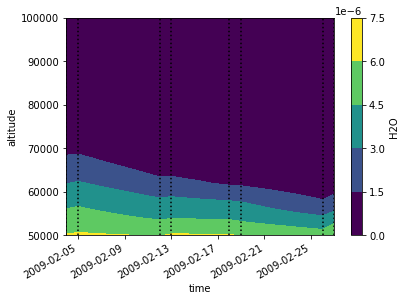

In [22]:
# profile = 'Temperature'
# # url = baseurl+'Odin-SMR_L2_ALL-Meso-v3.0.0_Temperature-557-(Fmode-13)-45-to-90-km_2009-{}.nc'.format(month)
# url = baseurl+'Odin-SMR_L2_ALL19lowTunc_Temperature-557-(Fmode-19)-45-to-90-km_2009-{}.nc'.format(month)
profile = 'H2O'
# url = baseurl+'ALL-Meso-v3.0.0/Odin-SMR_L2_ALL19lowTunc_H2O-557-GHz-45-to-100-km_2009-{}.nc'.format(month)
url = baseurl+'ALL-Meso-v3.0.0/Odin-SMR_L2_ALL-Meso-v3.0.0_H2O-557-GHz-45-to-100-km_2009-{}.nc'.format(month)
download_from_url(url)

filename = url.split('/')[-1]
#load nc file
with xr.open_dataset(path_save+filename) as ds:
    ds = ds.assign_coords(pressure=ds.Pressure[0]).swap_dims({"level":"pressure"})
    ds = ds.rename(dict(Profile=profile))

#interpolate in altitude grid
# alt_range = np.arange(50,101,1)*1000 #meter

ds_alt = alt_interp(ds, profile=profile, alt_range=alt_range)

#daily average in NP (lat > 70 degree)
ds_daily = ds_alt[profile].where(ds_alt.latitude>70).resample(time='1D').mean('time')
ds_daily.interpolate_na('time').plot.contourf(x='time')

#days with data
days_with_data = ds_daily.dropna('time', how='all').time.data
for t in days_with_data:
    plt.axvline(x=t, color='k', ls=':')

In [23]:
#calculate all latitudes
if 'Daily_'+filename not in listdir(path_save):
    ds_daily = mk_daily(ds_alt, [profile])
    ds_daily.to_netcdf(path_save+'Daily_'+filename)
    print('nc file saved!')
else:
    ds_daily = xr.open_dataset(path_save+'Daily_'+filename)
    ds_daily.close()
    print('array loaded!')

# ds_daily.isel(latitude=-1).Temperature_mean.interpolate_na('time').plot(x='time')
# for t in days_with_data:
#     plt.axvline(x=t, color='k', ls=':')

nc file saved!


## Play with some plots

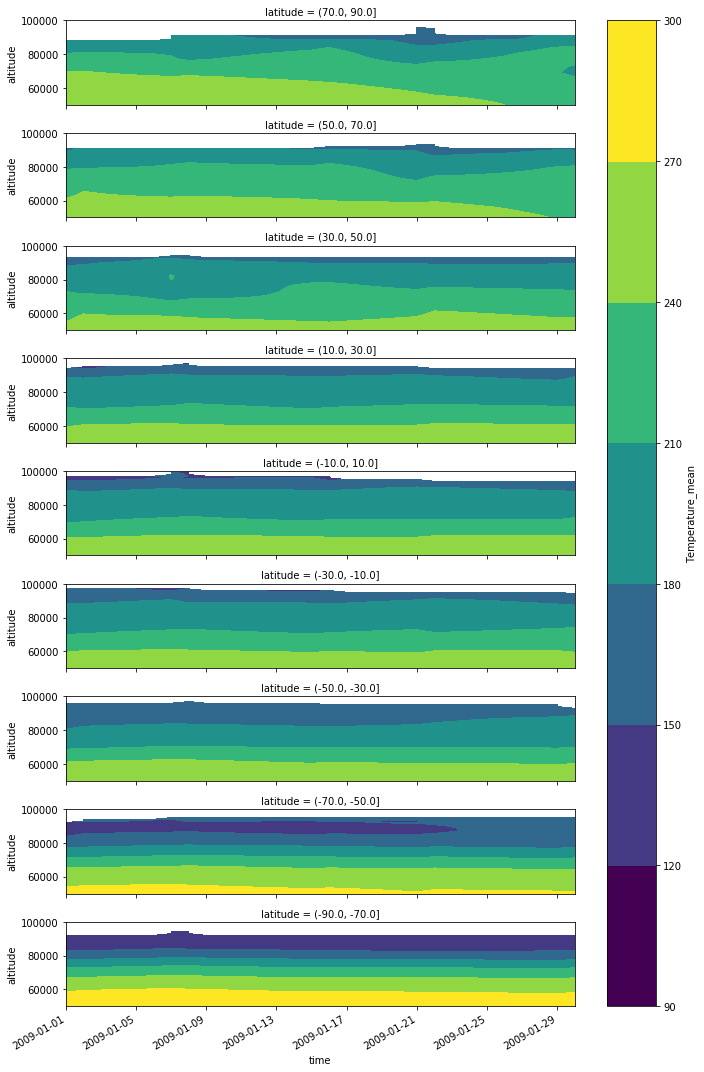

In [152]:
ds_daily.sel(latitude=ds_daily.latitude[::-1]).Temperature_mean.interpolate_na('time').plot.contourf(
    x='time', 
    row='latitude',
    figsize=(10,15)
    )

## Try longitude bins

In [260]:
import warnings
warnings.filterwarnings("ignore")

lon_bins = np.arange(0, 361, 5)
lat_bins = np.arange(-90, 91, 10)
lon_labels = []

daily_mean = []
for lon_label, lon_group in ds_alt.groupby_bins(ds_alt.longitude, bins=lon_bins):
    lon_labels.append(lon_label.mid) #make the labels to mid point so that we can save in nc file
    lat_lon_mean = []
    lat_labels = []
    for lat_label, lat_lon_group in lon_group.groupby_bins(lon_group.latitude, bins=lat_bins):
        lat_labels.append(lat_label.mid)
        resampled = lat_lon_group.Temperature.resample(time='1D')
        lat_lon_mean.append(resampled.mean('time').rename('Temperature_mean'))
    lat_lon_mean = xr.concat(lat_lon_mean, dim='latitude').assign_coords(latitude=lat_labels).sortby('latitude')
    daily_mean.append(lat_lon_mean)
ds_daily = xr.concat(daily_mean, dim='longitude').assign_coords(longitude=lon_labels).sortby('longitude')
ds_daily

<xarray.DataArray 'Temperature_mean' (longitude: 72, latitude: 18, time: 30, altitude: 51)>
array([[[[       nan, ...,        nan],
         ...,
         [       nan, ...,        nan]],

        ...,

        [[       nan, ...,        nan],
         ...,
         [224.484452, ...,        nan]]],


       ...,


       [[[       nan, ...,        nan],
         ...,
         [       nan, ...,        nan]],

        ...,

        [[       nan, ...,        nan],
         ...,
         [       nan, ...,        nan]]]])
Coordinates:
  * latitude   (latitude) float64 -85.0 -75.0 -65.0 -55.0 ... 65.0 75.0 85.0
  * time       (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-01-30
  * altitude   (altitude) int64 50000 51000 52000 53000 ... 98000 99000 100000
  * longitude  (longitude) float64 2.5 7.5 12.5 17.5 ... 342.5 347.5 352.5 357.5

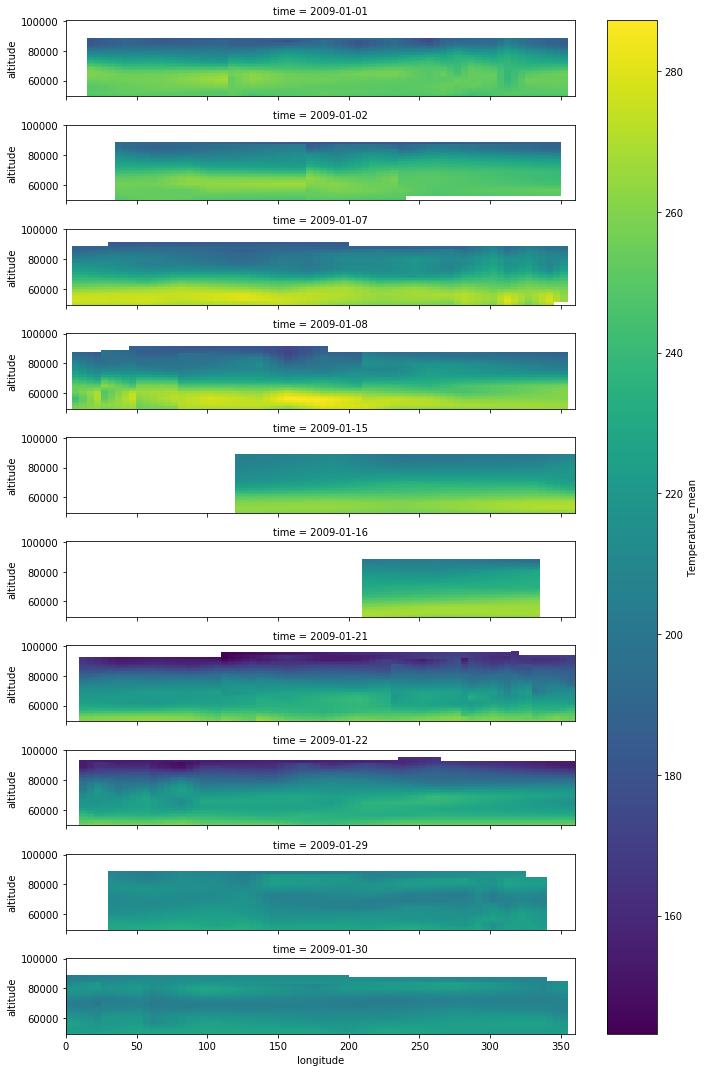

In [261]:
ds_daily.isel(latitude=-1).dropna('time','all'
).interpolate_na('longitude'
).plot(x='longitude', row='time', figsize=(10,15))



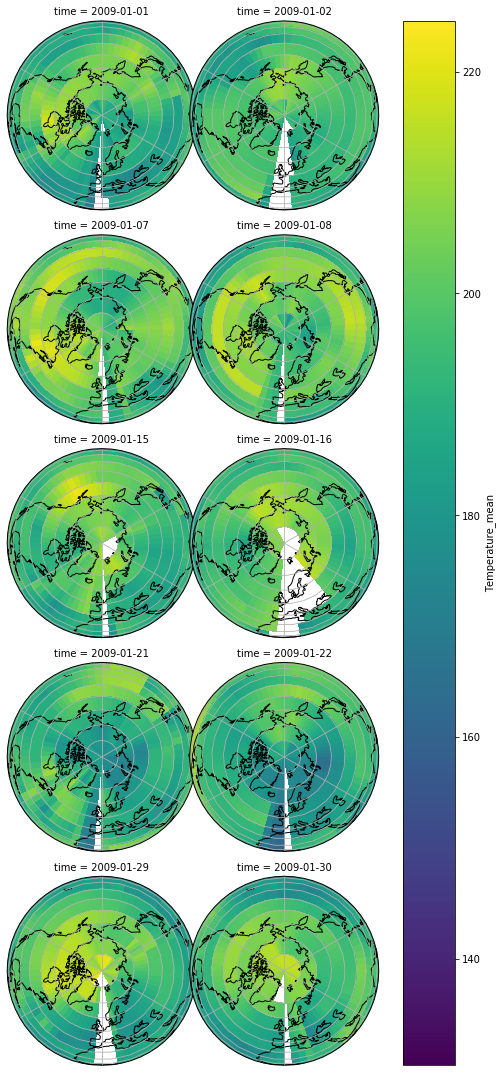

In [282]:
import cartopy.crs as ccrs
p = ds_daily.dropna('time','all').sel(altitude=85e3, #latitude=slice(0,90)
    ).interpolate_na('longitude'
    ).interpolate_na('latitude'
    ).plot(
        x='longitude',
        # y='latitude',
        col='time', col_wrap=2,
        subplot_kws=dict(projection=ccrs.Orthographic(0, 90), facecolor="gray"),
        transform=ccrs.PlateCarree(),
        add_colorbar=True,
    )
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()
